In [1]:
import numpy as np
#from matplotlib import pyplot
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from matplotlib import animation
from IPython.display import HTML

In [3]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

In [4]:
def update_plot(n, T):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    T[n] : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2} \n'.format(n),y=0.96)
    line.set_ydata(T[n])

In [5]:
# Define the rod properties
L_total = 0.09  # Total length of the rod (m)
nx = 51  # Total number of spatial points
dx = L_total / (nx - 1)  # Spatial step size

# Define material regions
L_material1 = 0.07
  # Length of first material
nx1 = int(nx * (L_material1 / L_total))  # Number of points in material 1
nx2 = nx - nx1  # Number of points in material 2

materials = [
    {'rho': 1490, 'k': lambda T: 1.148 + 0.0005315 * (T - 293), 'Cp': lambda T: 753.622+1.55*(T-293)-0.001403*(T-293)**2},
    {'rho': 200, 'k': lambda T: 0.031675-6.80767e-5*(T-293)+3.007e-7*(T-293)**2, 'Cp': lambda T: 840},
]

# Define temperature-dependent material properties
def k_func(T, region):
    """Thermal conductivity as a function of temperature."""
    if region == 1:  # Refractory brick
        return 1.0 + 0.0005 * (T - 300)  # Small increase with temperature
    else:  # Ceramic insulating wool
        return 0.05 + 0.0001 * (T - 300)  # Small increase with temperature

def rho_func(T, region):
    """Density as a function of temperature."""
    if region == 1:  # Refractory brick
        return 2200 -0.0001*(T-300)  # Constant
    else:  # Ceramic wool
        return 300 - 0.02 * (T - 300)  # Slight decrease with temperature

def Cp_func(T, region):
    """Specific heat capacity as a function of temperature."""
    if region == 1:  # Refractory brick
        return 1000 + 0.2 * (T - 300)  # Increase with temperature
    else:  # Ceramic wool
        return 1200 + 0.3 * (T - 300)  # Increase with temperature

In [6]:
# Define temperature-dependent material properties (example functions)
def k_func(T, region):
    """Thermal conductivity as a function of temperature for each material."""
    if region == 1:
        return 0.6 + 0.0005315 * (T - 293)  # Example: increases slightly with T
    else:
        return 0.00000025*(T-293)**2+0.00011*(T-293)+0.044
        #return 0.031675-6.80767e-5*(T-293)+3.007e-7*(T-293)**2  # Different response for material 2

def rho_func(T, region):
    """Density as a function of temperature for each material."""
    if region == 1:
        return 1490 - 0.01 * (T - 293)  # Example: decreases slightly with T
    else:
        return 200 - 0.005 * (T - 293)  # Different response for material 2

def Cp_func(T, region):
    """Specific heat capacity as a function of temperature for each material."""
    if region == 1:
        return 753.622+1.55*(T-293)-0.001403*(T-293)**2  # Example: increases slightly with T
    else:
        #return 850 - 10 * (T - 293)  # Different response for material 2
        return 850  # Different response for material 2

In [7]:
# Set initial temperature distribution
T0 = np.zeros(nx)
T0[:] = 293  # Initial uniform temperature
Tinf = 293  # Ambient temperature
#T0[0]=800+273.15
A = 0.1914  # Surface area
h = 10  # Convective heat transfer coefficient
boltzmann = 5.6704E-08  # Stefan-Boltzmann constant
Qdot_in = 2500  # Heat input

In [8]:
def ftcs_multi_material(T0, nt, dx):
    """
    Solves the transient heat equation with temperature-dependent properties 
    and multiple materials.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        Initial temperature distribution.
    nt : int
        Number of time steps.
    dx : float
        Spatial step size.
    
    Returns
    -------
    T_hist : list
        Temperature distribution history.
    """
    T = T0.copy()
    T_hist = [T0.copy()]

    for n in range(nt):
        T_new = T.copy()

        # Update material properties at each spatial point
        k_vals = np.array([k_func(T[i], 1) if i < nx1 else k_func(T[i], 2) for i in range(nx)])
        rho_vals = np.array([rho_func(T[i], 1) if i < nx1 else rho_func(T[i], 2) for i in range(nx)])
        Cp_vals = np.array([Cp_func(T[i], 1) if i < nx1 else Cp_func(T[i], 2) for i in range(nx)])
        alpha_vals = k_vals / (rho_vals * Cp_vals)

        # Compute stable time step dynamically
        dt = min(0.5 * dx**2 / max(alpha_vals), 1.0)

        # Update temperature for interior points
        for i in range(1, nx - 1):
            sigma = alpha_vals[i] * dt / dx**2

            # Handle interface continuity (material junction at nx1)
            if i == nx1:
                k_left, k_right = k_vals[i - 1], k_vals[i]
                T_left, T_right = T[i - 1], T[i + 1]

                # Compute flux continuity
                T_new[i] = (k_right * T_left + k_left * T_right) / (k_left + k_right)
            else:
                T_new[i] = T[i] + sigma * (T[i + 1] - 2 * T[i] + T[i - 1])

        # Boundary conditions
        Qdot_out = boltzmann * A * (T[-1]**4 - Tinf**4) + h * A * (T[-1] - Tinf)
        heatfac = dx / (k_vals[0] * A)

        
        T_new[0] += (alpha_vals[0] * dt / dx**2) * (T[1] - T[0] + heatfac * Qdot_in)
        #T_new[0] = T[0]
        T_new[-1] += (alpha_vals[-1] * dt / dx**2) * (T[-2] - T[-1] - heatfac * Qdot_out)
        
        T = T_new.copy()
        T_hist.append(T.copy())

    return T_hist

In [9]:
# Set simulation parameters
sigma = 0.5  # CFL condition safety factor
dt_initial = sigma * dx**2 / (max(k_func(T0, 1)) / (min(rho_func(T0, 1)) * min(Cp_func(T0, 1))))
dt = min(dt_initial, 1.0)  # Ensure stability
Tfinal = 10 * 3600  # Simulate for 6 hours
nt = int(Tfinal / dt)  # Number of time steps

# Run simulation
T = ftcs_multi_material(T0, nt, dx)

In [10]:
Taa=np.array(T)

In [11]:
Taa

array([[ 293.        ,  293.        ,  293.        , ...,  293.        ,
         293.        ,  293.        ],
       [ 299.46227944,  293.        ,  293.        , ...,  293.        ,
         293.        ,  293.        ],
       [ 304.78264928,  294.06574214,  293.        , ...,  293.        ,
         293.        ,  293.        ],
       ...,
       [1214.61261755, 1193.04013593, 1171.4681145 , ...,  357.59171026,
         355.80215065,  354.01315766],
       [1214.61271874, 1193.04023811, 1171.46821758, ...,  357.59176516,
         355.80220412,  354.01320959],
       [1214.61281991, 1193.04034027, 1171.46832065, ...,  357.59182006,
         355.80225758,  354.01326152]])

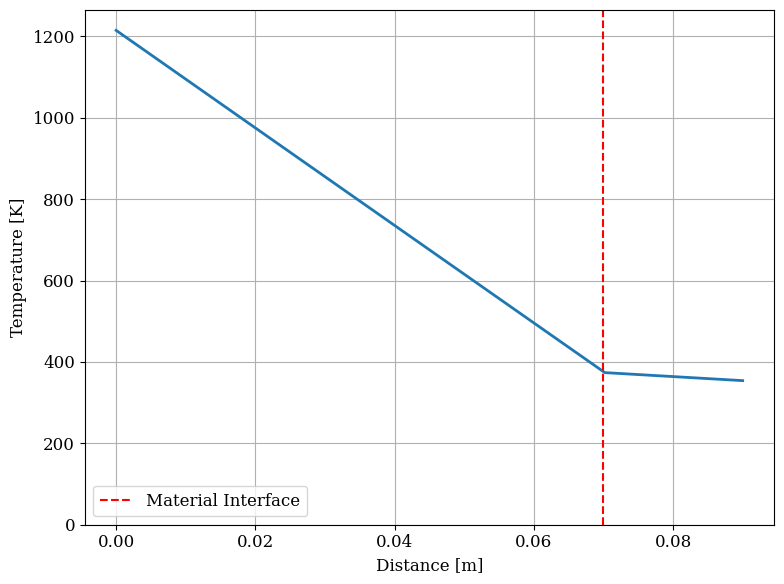

In [12]:
# Plot final temperature distribution
fig = plt.figure(figsize=(8, 6.0))
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]')
plt.grid()
line = plt.plot(np.linspace(0.0, L_total, num=nx), T[-1], color='C0', linestyle='-', linewidth=2)
plt.axvline(x=L_material1, color='red', linestyle='--', label="Material Interface")  # Mark the interface
plt.ylim(0.0, T[-1][0] + 50)
plt.legend()
plt.tight_layout()
plt.show()


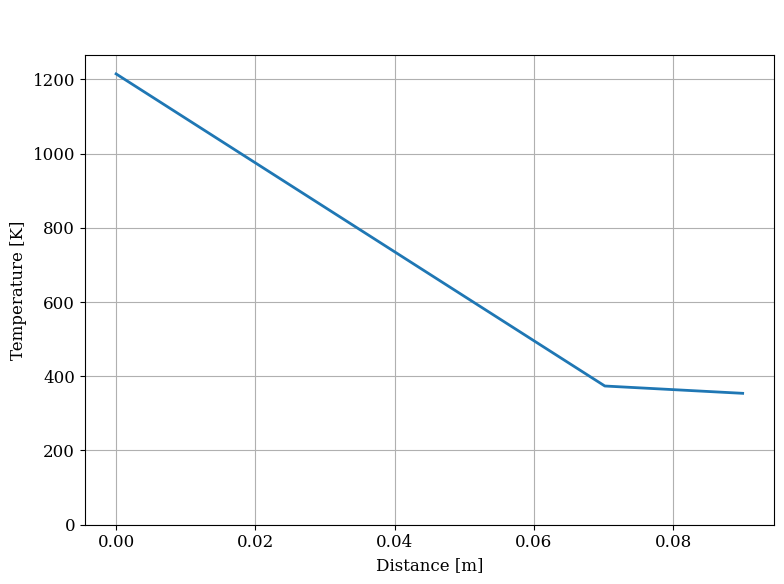

In [13]:
# Plot the initial traffic density.
fig = plt.figure(figsize=(8, 6.0))
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]')
plt.title('\n')
plt.grid()
line = plt.plot(np.linspace(0.0, L_total, num=nx), T[-1],
                   color='C0', linestyle='-', linewidth=2)[0]
#pyplot.xlim(0.0, L)
plt.ylim(0.0, T[-1][0]+50)
plt.tight_layout()

In [14]:
T[-1][0]

1214.6128199092857

In [15]:
T[-1][-1]

354.01326151597664

In [16]:
T[-1][0]-273.15

941.4628199092857

In [17]:
T[-1][-1]-273.15

80.86326151597666

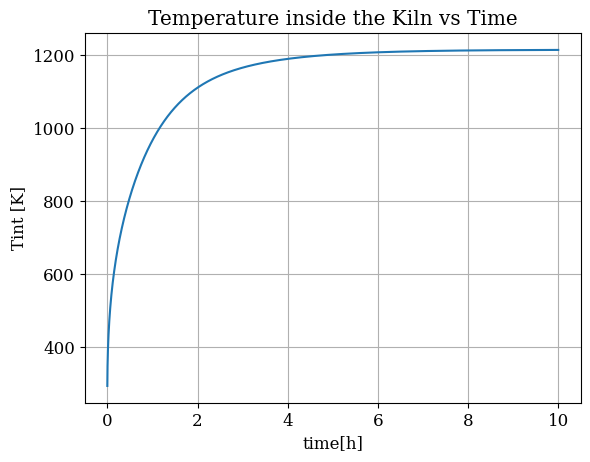

In [18]:
# Extract the first number of each subarray
first_elements = [subarray[0] for subarray in T]

# Print extracted elements for verification
#print("First elements of each subarray:", first_elements)
time = (np.linspace(0,nt*dt,nt+1))/3600
# Plotting the values
plt.plot(time,first_elements, linestyle='-')

plt.xlabel('time[h]')
plt.ylabel('Tint [K]')
plt.title('Temperature inside the Kiln vs Time')
plt.grid(True)
plt.show()

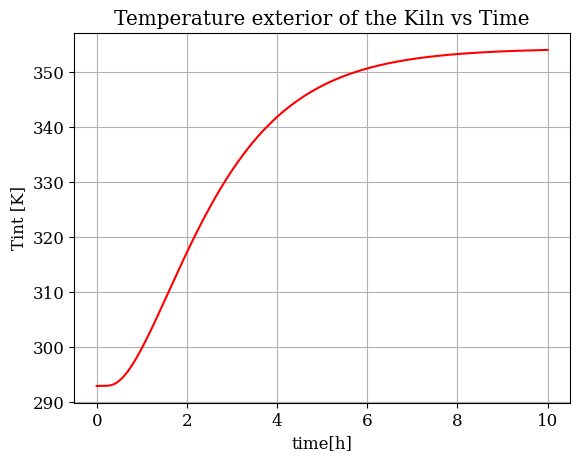

In [19]:
last_elements = [subarray[-1] for subarray in T]

plt.plot(time,last_elements, linestyle='-',c='r')
plt.xlabel('time[h]')
plt.ylabel('Tint [K]')
plt.title('Temperature exterior of the Kiln vs Time')
plt.grid(True)
plt.show()

In [20]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=len(T[::500]), fargs=(T[::500],),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [21]:
# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='AndresMenes'),
                                bitrate=1800)
anim.save('temperature_explicit_kiln_2materials.gif', writer=writer)